# Offers in flight prediction

In [70]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import learning_curve

%matplotlib inline


## Read Data

In [71]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
import boto3
import base64

%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = '../../redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5


from sagemaker import get_execution_role
session = boto3.session.Session()
kms = session.client('kms')
encrypted_user = creds['username']
encrypted_pass = creds['password']
binary_data = base64.b64decode(encrypted_user)
meta = kms.decrypt(CiphertextBlob=binary_data)
user = meta[u'Plaintext']
binary_data = base64.b64decode(encrypted_pass)
meta2 = kms.decrypt(CiphertextBlob=binary_data)
passwd = meta2[u'Plaintext']
connect_to_db = 'postgresql+psycopg2://' + \
                user.decode() + ':' + passwd.decode() + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()


The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [137]:
query="""
SELECT * FROM ml_prep.gauthier_quantify_closed_door_view_2020_07_30 WHERE 
departure_local_date_time >= '2019-11-01 11:00:00' AND departure_local_date_time < '2020-02-01 11:00:00' 
and cabin_type='BUSINESS' AND average_upgrade_estimation_method_12m IN ('AVG_UPG_CABIN_ROUTE')
;
"""
raw_df = pd.read_sql_query(query, con)
raw_df.head(3)


flight_number carrier_code origination destination cabin_type  \
0            533           AM         MEX         MID   BUSINESS   
1            323           VA         MEL         BNE   BUSINESS   
2            710           MH         CGK         KUL   BUSINESS   

  scheduled_departure_local_date_time scheduled_arrival_local_date_time  \
0                 2019-11-01 11:00:00                                     
1                 2019-11-01 11:00:00                                     
2                 2019-11-01 11:10:00               2019-11-01 14:15:00   

  departure_local_date_time arrival_local_date_time  departure_date_utc  ...  \
0       2019-11-01 11:00:00                         2019-11-01 17:00:00  ...   
1       2019-11-01 11:00:00                         2019-11-01 00:00:00  ...   
2       2019-11-01 11:10:00     2019-11-01 14:15:00 2019-11-01 04:10:00  ...   

  origination_city  destination_country  destination_city  \
0      Mexico City               Mexico            Merida   
1        Melbourne            Australia          Brisbane   
2          Jakarta             Malaysia      Kuala Lumpur   

   flight_availability_event_date  flight_availability_version  \
0         2019-11-01 16:15:17.348                         1.20   
1         2019-10-31 23:15:14.757                         1.20   
2         2019-11-01 03:58:30.464                         1.20   

   flight_inventory_event_date  flight_inventory_version  \
0                          NaT                             
1                          NaT                             
2                          NaT                             

   inventory_departure_local_date_time  inventory_arrival_local_date_time  \
0                                  NaT                                NaT   
1                                  NaT                                NaT   
2                                  NaT                                NaT   

          update_time  
0 2020-07-30 12:01:48  
1 2020-07-30 12:01:48  
2 2020-07-30 12:01:48  

[3 rows x 51 columns]

In [138]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596274 entries, 0 to 596273
Data columns (total 51 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   flight_number                           596274 non-null  int64         
 1   carrier_code                            596274 non-null  object        
 2   origination                             596274 non-null  object        
 3   destination                             596274 non-null  object        
 4   cabin_type                              596274 non-null  object        
 5   scheduled_departure_local_date_time     596274 non-null  object        
 6   scheduled_arrival_local_date_time       596274 non-null  object        
 7   departure_local_date_time               596274 non-null  object        
 8   arrival_local_date_time                 596274 non-null  object        
 9   departure_date_utc                   

# Feature Engineering

In [139]:
#drop non relevant fields
df = raw_df.drop(['average_upgrade_estimation_method_1m',
                  'average_upgrade_estimation_method_3m',
                  'average_upgrade_estimation_method_6m',
                  'average_upgrade_estimation_method_12m',
                 'flight_availability_event_date',
                 'flight_availability_version',
                 'flight_inventory_event_date',
                 'flight_inventory_version',
                 'inventory_departure_local_date_time',
                 'inventory_arrival_local_date_time',
                 'update_time',
                 'estimated_lost_revenue_usd_1m',
                 'estimated_lost_revenue_usd_3m',
                 'estimated_lost_revenue_usd_6m',
                 'estimated_lost_revenue_usd_12m',
                 'last_check_minutes',
                 'raw_available_count',
                 'waitlisted_seats',
                 'booked_seats',
                 'load_factor',
                 'partner_code',
                 'partner_name',
                 'upgrade_item_count_sum',
                 'scheduled_departure_local_date_time',
                 'scheduled_arrival_local_date_time'], axis=1)



In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596274 entries, 0 to 596273
Data columns (total 26 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   flight_number                           596274 non-null  int64         
 1   carrier_code                            596274 non-null  object        
 2   origination                             596274 non-null  object        
 3   destination                             596274 non-null  object        
 4   cabin_type                              596274 non-null  object        
 5   departure_local_date_time               596274 non-null  object        
 6   arrival_local_date_time                 596274 non-null  object        
 7   departure_date_utc                      596274 non-null  datetime64[ns]
 8   arrival_date_utc                        588068 non-null  datetime64[ns]
 9   authorized_capacity                  

In [141]:
# compute some time-related features
# this takes some time

def feature_engineering(df):
    df['departure_hour'] = pd.to_datetime(df['departure_local_date_time']).apply(lambda x: x.hour)
    df['departure_day_of_week']= pd.to_datetime(df['departure_local_date_time']).apply(lambda x: x.dayofweek)
    df['departure_month']= pd.to_datetime(df['departure_local_date_time']).apply(lambda x: x.month)
    df['departure_year']= pd.to_datetime(df['departure_local_date_time']).apply(lambda x: x.year)
    
    df['arrival_hour'] = pd.to_datetime(df['arrival_local_date_time']).apply(lambda x: x.hour).fillna(0)
    df['arrival_day_of_week']= pd.to_datetime(df['arrival_local_date_time']).apply(lambda x: x.dayofweek).fillna(0)
    df['arrival_month']= pd.to_datetime(df['arrival_local_date_time']).apply(lambda x: x.month).fillna(0)
    df['arrival_year']= pd.to_datetime(df['arrival_local_date_time']).apply(lambda x: x.year).fillna(0)

    df['origination_destination'] = df['origination']+ df['destination']
    df['origination_destination_country'] = df['origination_country']+ df['destination_country']
    df['origination_destination_city'] = df['origination_city']+ df['destination_city']
    df['offer_submitted'] = df['offer_submitted_item_count_sum']+ df['offer_cancelled_item_count_sum']

    df['operational_capacity'] = df['operational_capacity'].fillna(0)
    df['authorized_capacity'] = df['authorized_capacity'].fillna(0)

    return df

df = feature_engineering(df)
raw_df = feature_engineering(raw_df)


In [142]:
df[['offer_submitted','offer_submitted_item_count_sum','offer_cancelled_item_count_sum']][:3]

offer_submitted  offer_submitted_item_count_sum  \
0                2                               2   
1                2                               2   
2                3                               3   

   offer_cancelled_item_count_sum  
0                               0  
1                               0  
2                               0

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596274 entries, 0 to 596273
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   flight_number                           596274 non-null  int64         
 1   carrier_code                            596274 non-null  object        
 2   origination                             596274 non-null  object        
 3   destination                             596274 non-null  object        
 4   cabin_type                              596274 non-null  object        
 5   departure_local_date_time               596274 non-null  object        
 6   arrival_local_date_time                 596274 non-null  object        
 7   departure_date_utc                      596274 non-null  datetime64[ns]
 8   arrival_date_utc                        588068 non-null  datetime64[ns]
 9   authorized_capacity                  

# Feature Encoding

In [144]:
# for random forest, no need to one-hot-encode
def label_encode_categorical(df, columns):
    train_df_fact = df.copy()
    for column in columns:
        print('label encoding',column,'...')
        encoder = preprocessing.LabelEncoder()
        encoder.fit(train_df_fact[column])
        train_df_fact[column+'_encoded'] = encoder.transform(train_df_fact[column])
    return train_df_fact


In [145]:
# label-encode categories
df= label_encode_categorical(df,['carrier_code',
                                 'origination',
                                 'destination',
                                 'cabin_type',
                                 'origination_destination',
                                 'origination_country',
                                 'origination_city',
                                 'destination_country',
                                 'destination_city',
                                 'origination_destination_country',
                                 'origination_destination_city'])

label encoding carrier_code ...
label encoding origination ...
label encoding destination ...
label encoding cabin_type ...
label encoding origination_destination ...
label encoding origination_country ...
label encoding origination_city ...
label encoding destination_country ...
label encoding destination_city ...
label encoding origination_destination_country ...
label encoding origination_destination_city ...


# Label encoding

In [146]:
bin_labels = ['NO_OFFER', '1_OR_2_OFFERS', '3_OR_MORE_OFFERS']

df['offer_submitted_bucket'] =pd.cut(df['offer_submitted'],  [-1, 0, 2, 1000], labels=bin_labels)

In [147]:
df.groupby('offer_submitted_bucket').size()

offer_submitted_bucket
NO_OFFER            374337
1_OR_2_OFFERS       135268
3_OR_MORE_OFFERS     86669
dtype: int64

In [148]:
df[['offer_submitted','offer_submitted_bucket']][:300]

offer_submitted offer_submitted_bucket
0                  2          1_OR_2_OFFERS
1                  2          1_OR_2_OFFERS
2                  3       3_OR_MORE_OFFERS
3                  7       3_OR_MORE_OFFERS
4                  4       3_OR_MORE_OFFERS
..               ...                    ...
295                2          1_OR_2_OFFERS
296                2          1_OR_2_OFFERS
297                0               NO_OFFER
298                2          1_OR_2_OFFERS
299                6       3_OR_MORE_OFFERS

[300 rows x 2 columns]

In [149]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(df['offer_submitted_bucket'])
df['offer_submitted_bucket_encoded'] = label_encoder.transform(df['offer_submitted_bucket'])

In [150]:
label_encoder.classes_

array(['1_OR_2_OFFERS', '3_OR_MORE_OFFERS', 'NO_OFFER'], dtype=object)

In [151]:
df['offer_submitted_bucket_encoded'][:10]

0    0
1    0
2    1
3    1
4    1
5    2
6    0
7    0
8    0
9    1
Name: offer_submitted_bucket_encoded, dtype: int64

In [152]:
df.head(3)

flight_number carrier_code origination destination cabin_type  \
0            533           AM         MEX         MID   BUSINESS   
1            323           VA         MEL         BNE   BUSINESS   
2            710           MH         CGK         KUL   BUSINESS   

  departure_local_date_time arrival_local_date_time  departure_date_utc  \
0       2019-11-01 11:00:00                         2019-11-01 17:00:00   
1       2019-11-01 11:00:00                         2019-11-01 00:00:00   
2       2019-11-01 11:10:00     2019-11-01 14:15:00 2019-11-01 04:10:00   

     arrival_date_utc  authorized_capacity  ...  cabin_type_encoded  \
0                 NaT                  0.0  ...                   0   
1                 NaT                  8.0  ...                   0   
2 2019-11-01 06:15:00                 11.0  ...                   0   

   origination_destination_encoded  origination_country_encoded  \
0                             2926                          106   
1                             2854                            8   
2                             1009                           78   

   origination_city_encoded  destination_country_encoded  \
0                       357                          106   
1                       353                            8   
2                       247                           99   

   destination_city_encoded  origination_destination_country_encoded  \
0                       356                                     1119   
1                        88                                       27   
2                       288                                      769   

   origination_destination_city_encoded  offer_submitted_bucket  \
0                                  2703           1_OR_2_OFFERS   
1                                  2633           1_OR_2_OFFERS   
2                                  1766        3_OR_MORE_OFFERS   

   offer_submitted_bucket_encoded  
0                               0  
1                               0  
2                               1  

[3 rows x 51 columns]

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596274 entries, 0 to 596273
Data columns (total 51 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   flight_number                            596274 non-null  int64         
 1   carrier_code                             596274 non-null  object        
 2   origination                              596274 non-null  object        
 3   destination                              596274 non-null  object        
 4   cabin_type                               596274 non-null  object        
 5   departure_local_date_time                596274 non-null  object        
 6   arrival_local_date_time                  596274 non-null  object        
 7   departure_date_utc                       596274 non-null  datetime64[ns]
 8   arrival_date_utc                         588068 non-null  datetime64[ns]
 9   authorized_capacity       

In [198]:
columns_for_training= [
    
             #'cabin_type',
    
            # o/d
            'origination_encoded',
            'origination_city_encoded',
            'origination_country_encoded',
            'destination_encoded',
            'destination_city_encoded',
            'destination_country_encoded',
            'origination_destination_encoded',
            'origination_destination_country_encoded',
            'origination_destination_city_encoded',
            
            # departure time
            'departure_hour',
            'departure_day_of_week',
            'departure_month',
            'departure_year',
    
            # arrival time
            'arrival_hour',
            'arrival_day_of_week',
            'arrival_month',
            'arrival_year',

            # cabin capacity
            'authorized_capacity',
            'operational_capacity',
    
            # historical average upgrade amount
            'average_upgrade_amount_usd_1m',
            'average_upgrade_amount_usd_3m',
            'average_upgrade_amount_usd_6m',
            'average_upgrade_amount_usd_12m',
    
            # the rest
            'flight_distance_miles',
            'flight_number',
            'carrier_code_encoded',
            'partner_id',

            # target
            'offer_submitted_bucket_encoded'
                      ]

df_train = df[columns_for_training]

In [199]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596274 entries, 0 to 596273
Data columns (total 28 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   origination_encoded                      596274 non-null  int64  
 1   origination_city_encoded                 596274 non-null  int64  
 2   origination_country_encoded              596274 non-null  int64  
 3   destination_encoded                      596274 non-null  int64  
 4   destination_city_encoded                 596274 non-null  int64  
 5   destination_country_encoded              596274 non-null  int64  
 6   origination_destination_encoded          596274 non-null  int64  
 7   origination_destination_country_encoded  596274 non-null  int64  
 8   origination_destination_city_encoded     596274 non-null  int64  
 9   departure_hour                           596274 non-null  int64  
 10  departure_day_of_week           

In [200]:
df_train.head(4)

origination_encoded  origination_city_encoded  origination_country_encoded  \
0                  360                       357                          106   
1                  359                       353                            8   
2                  100                       247                           78   
3                  540                       541                            8   

   destination_encoded  destination_city_encoded  destination_country_encoded  \
0                  366                       356                          106   
1                   70                        88                            8   
2                  302                       288                           99   
3                  152                       152                           78   

   origination_destination_encoded  origination_destination_country_encoded  \
0                             2926                                     1119   
1                             2854                                       27   
2                             1009                                      769   
3                             4051                                       35   

   origination_destination_city_encoded  departure_hour  ...  \
0                                  2703              11  ...   
1                                  2633              11  ...   
2                                  1766              11  ...   
3                                  4093              11  ...   

   operational_capacity  average_upgrade_amount_usd_1m  \
0                   0.0                             72   
1                   8.0                            101   
2                  16.0                            111   
3                   8.0                            248   

   average_upgrade_amount_usd_3m  average_upgrade_amount_usd_6m  \
0                             65                             61   
1                            133                            124   
2                            101                            100   
3                            271                            280   

   average_upgrade_amount_usd_12m  flight_distance_miles  flight_number  \
0                              65                    623            533   
1                             121                    859            323   
2                             101                    704            710   
3                             280                   2888             33   

   carrier_code_encoded  partner_id  offer_submitted_bucket_encoded  
0                     4         187                               0  
1                    48          35                               0  
2                    28         441                               1  
3                    48          35                               1  

[4 rows x 28 columns]

In [201]:
df_train.groupby('departure_year').size()

departure_year
2019    357416
2020    238858
dtype: int64

# Model Training & Evaluation

In [202]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cbar=False)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [203]:
def train_and_evaluate(df_to_train,raw_df, plot_learning_curves=False, limit=None, split_on_time=False, run_sim=False):
    # X-validation
    from sklearn.preprocessing import label_binarize
    from sklearn.multiclass import OneVsRestClassifier
    
    if limit is not None:
        #pick them randomly
        df_to_train = df_to_train.sample(n=limit,random_state=42)
        raw_df = raw_df.sample(n=limit,random_state=42)

    random_forest =  OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
    X = df_to_train.drop("offer_submitted_bucket_encoded", axis=1)
    y_raw = df_to_train["offer_submitted_bucket_encoded"]
    
    y = label_binarize(y_raw, classes=[0, 1, 2])

    n_classes = y.shape[1]
    
    if split_on_time:
        X_train = X[X["departure_year"] == 2019 ].drop("departure_year", axis=1)
        y_train = y[X["departure_year"] == 2019]
        X_test = X[X["departure_year"] == 2020].drop("departure_year", axis=1)
        y_test = y[X["departure_year"] == 2020]
        X_test_raw = raw_df[raw_df["departure_year"] == 2020]
    else:
        X = X.drop("departure_year", axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)
        X_train_raw, X_test_raw = train_test_split(raw_df, test_size=0.30, random_state=42)


    # train
    print('training on', str(len(X_train)), 'rows...')
    random_forest.fit(X_train, y_train)
    print('training is done!')
    print('testing on', str(len(X_test)), 'rows...')

    # predict
    y_test_proba = random_forest.predict_proba(X_test)
    y_test_predict = random_forest.predict(X_test)

    #print('y_test_proba',y_test_proba)
    #print('y_test_predict',y_test_predict)
    # evaluation metrics

    roc_auc = dict()
    
    colors = ['red', 'blue', 'green']
    
    plt.figure(figsize=(16,9))
    for i,color in zip(range(n_classes),colors):
        fpr, tpr, _ = metrics.roc_curve(y_test[:, i], y_test_proba[:, i])
        plt.title('ROC')
        plt.plot([0, 1], [0,1], 'k--')
        roc_auc_for_one_class=metrics.auc(fpr, tpr)
        roc_auc[i] = roc_auc_for_one_class
        plt.plot(fpr, tpr,marker='.',color=color, label='{0} (AUC = {1:0.2f})'.format(label_encoder.classes_[i], roc_auc_for_one_class))
        plt.legend(loc="center right")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
    roc_auc = metrics.roc_auc_score(y_test,y_test_proba,multi_class="ovr")
    
    print('global roc_auc',roc_auc)
    
    
    plt.figure(figsize=(16,9))
    for i,color in zip(range(n_classes),colors):
        precisions, recalls, thresholds = metrics.precision_recall_curve(y_test[:, i], y_test_proba[:, i])
        plt.title('Precision-Recall')
        roc_pr_for_one_class=metrics.auc(recalls, precisions)
        plt.plot(recalls, precisions,marker='.',color=color, label='{0} (AUC = {1:0.2f})'.format(label_encoder.classes_[i], roc_pr_for_one_class))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="center right")
        # proportion of positive examples
        #no_skill = len(y[y==1]) / len(y)
        #plt.plot([0, 1], [no_skill, no_skill], linestyle='--')

    #print('precisions',precisions)
    #print('recalls',recalls)
    #print('thresholds',thresholds)

    precision,recall,f1,support = metrics.precision_recall_fscore_support(y_test,y_test_predict)

    for i in range(n_classes):
        print('#### CLASS',label_encoder.classes_[i],'####')
        print('precision', precision[i])
        print('recall', recall[i])
        print('f1', f1[i])
        print('support', support[i])

    cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_test_predict.argmax(axis=1))
    print_confusion_matrix(cm, label_encoder.classes_)
    
    for i in range(n_classes):
        features = X_train.columns
        importances = random_forest.estimators_[i].feature_importances_
        indices = np.argsort(importances)[::-1]
        #print('# EY offer strength prediction. Feature importance for',label_encoder.classes_[i])
        #for feature,importance in zip(features[indices],importances[indices]):
        #    print(feature+','+str(importance))
    
        # Plot the impurity-based feature importances of the forest
        plt.figure(figsize=(16,9))
        plt.title('Feature Importances for class '+ label_encoder.classes_[i])
        plt.bar(range(len(indices)), importances[indices], color='b', align='center')   
        plt.xticks(range(X_train.shape[1]), features[indices],rotation=90)
    
    
    if run_sim:
        threshold = 0.8    
        for i in range(n_classes):
            print('#### RUNNING SIMULATION FOR CLASS',label_encoder.classes_[i],'####')
            high_confidence_index = y_test_proba[:, i] > threshold
            high_confidence_X = X_test[high_confidence_index]
            high_confidence_raw_X = X_test_raw[high_confidence_index]
            

            print('number of high confidence rows',len(high_confidence_X.index),'(out of ',len(high_confidence_index),')')
            print(high_confidence_X['submission_hour'][:10])
            print(high_confidence_raw_X['submission_hour'][:10])
            
            real_high_confidence_total_offer_amount = high_confidence_raw_X['offer_amount_total_usd'].sum()
            
            print('Real offer $ : ',real_high_confidence_total_offer_amount)

            y_test_proba = random_forest.predict_proba(high_confidence_X)
            
    if plot_learning_curves:
        scoring = 'roc_auc'
        print('Computing Learning curves...')
        train_sizes, train_scores, test_scores = \
                learning_curve(random_forest, X, y, train_sizes=np.linspace(0.1, 1.0, 5), scoring=scoring, cv=2)

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(16,9))
        # Plot learning curve
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        plt.legend(loc="best")
        plt.xlabel("Training examples")
        plt.ylabel(scoring)
        plt.title("Learning Curves")


        print(train_sizes)
        print(train_scores)
        print(test_scores)

In [204]:
# run with a lot of data with time split
#train_and_evaluate(df_train,raw_df=raw_df, plot_learning_curves=False, limit=1000, split_on_time=True)

training on 357416 rows...
training is done!
testing on 238858 rows...
global roc_auc 0.7339443685567906
#### CLASS 1_OR_2_OFFERS ####
precision 0.291996852180597
recall 0.3298191214470284
f1 0.30975770754057624
support 48375
#### CLASS 3_OR_MORE_OFFERS ####
precision 0.5060447671866896
recall 0.38577120783526475
f1 0.4377977217811529
support 32877
#### CLASS NO_OFFER ####
precision 0.8048447964468681
recall 0.7266664974683705
f1 0.7637602824913388
support 157606


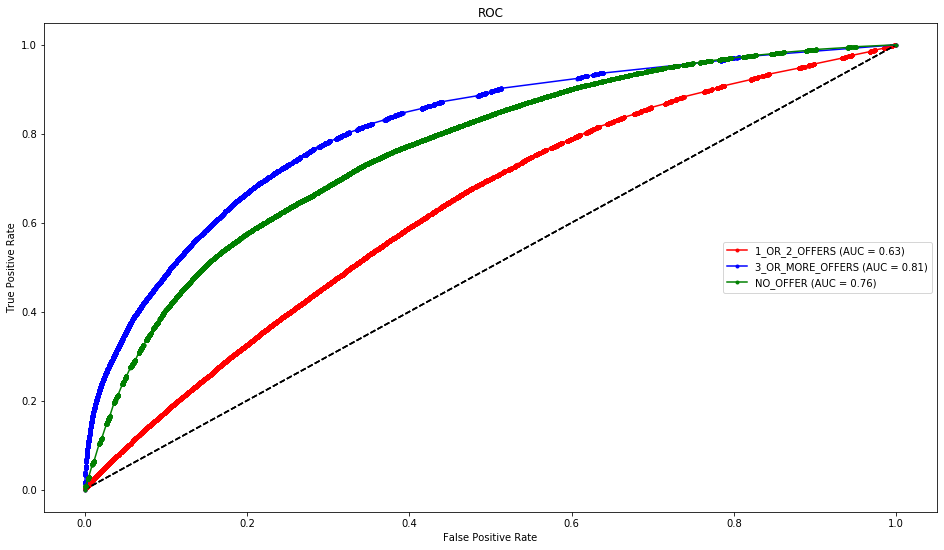

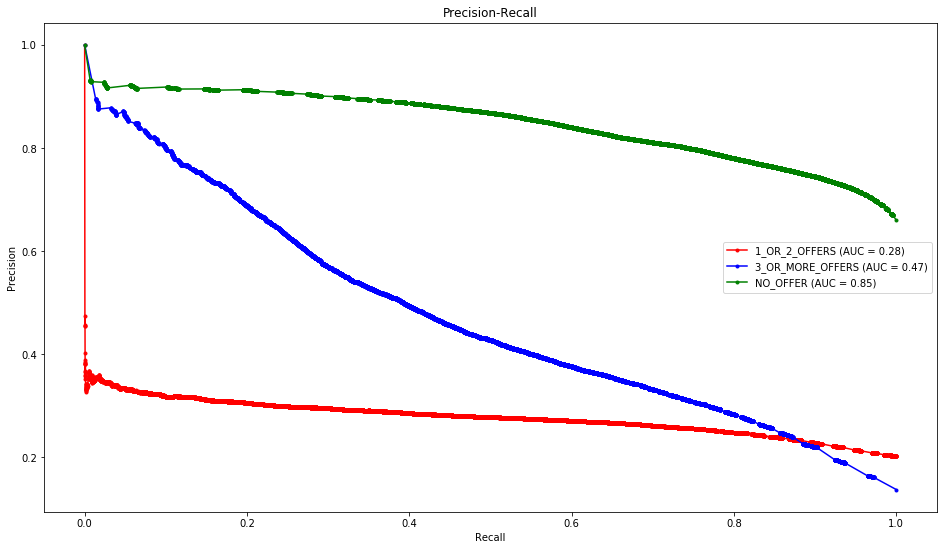

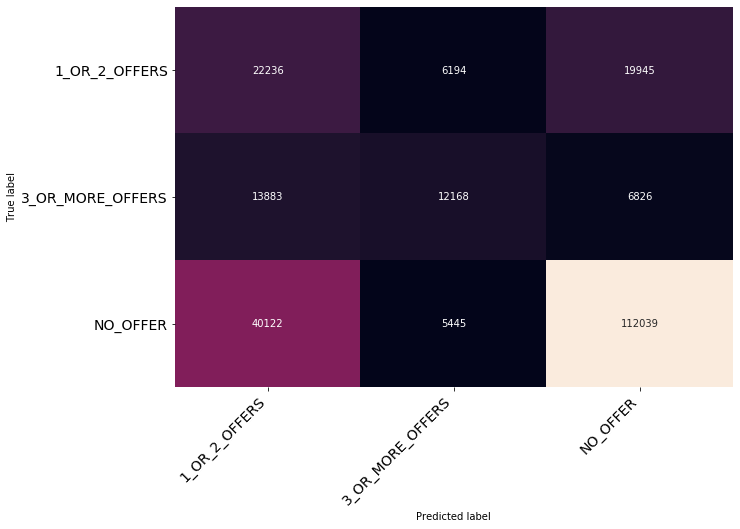

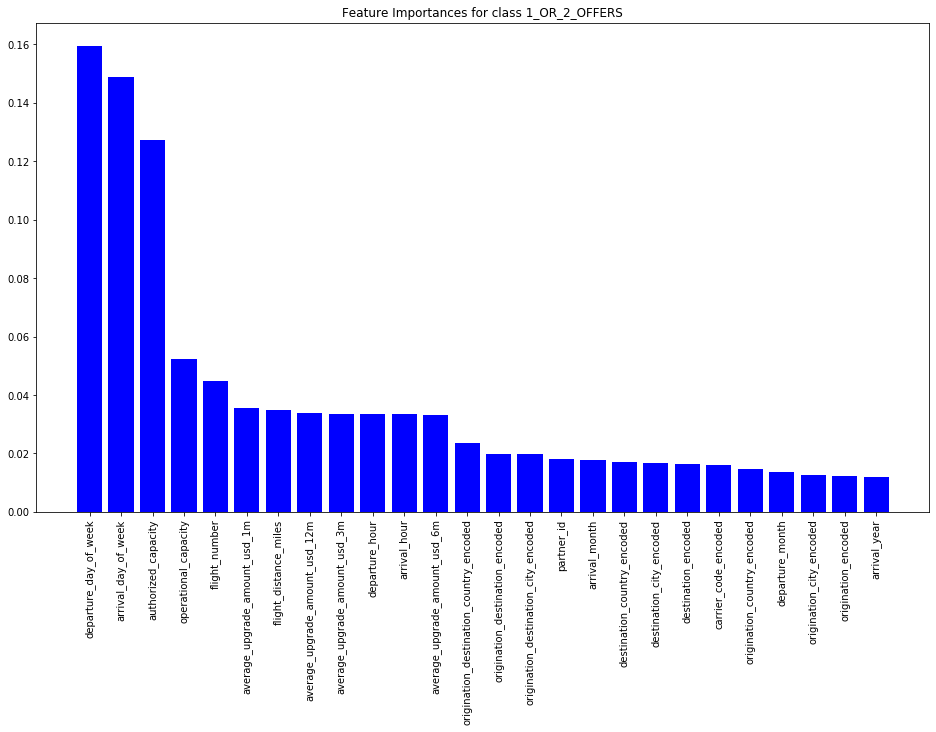

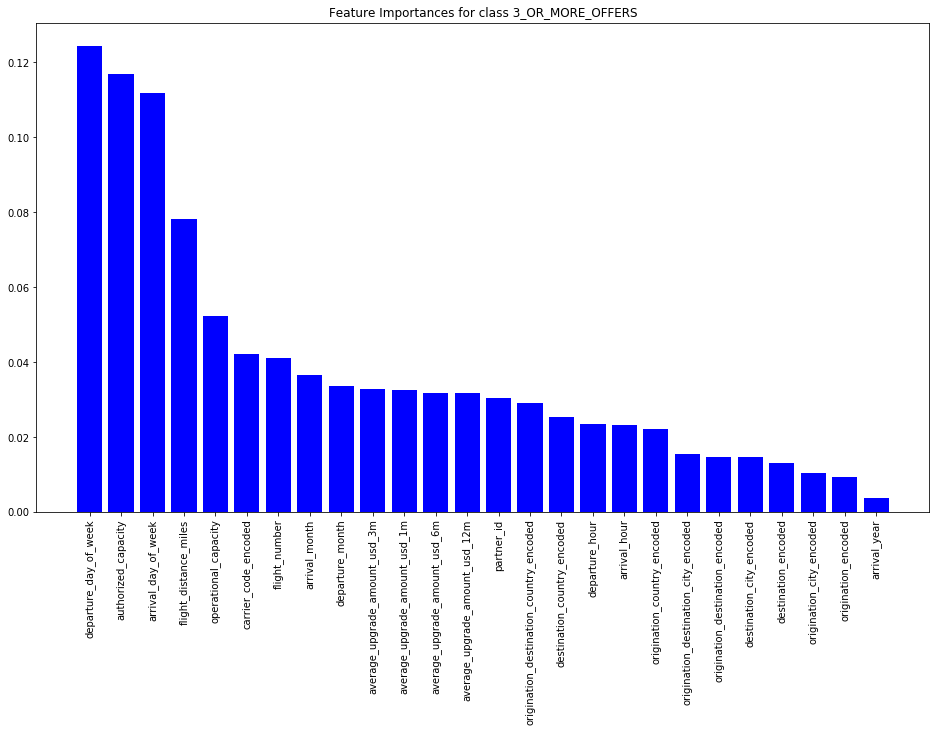

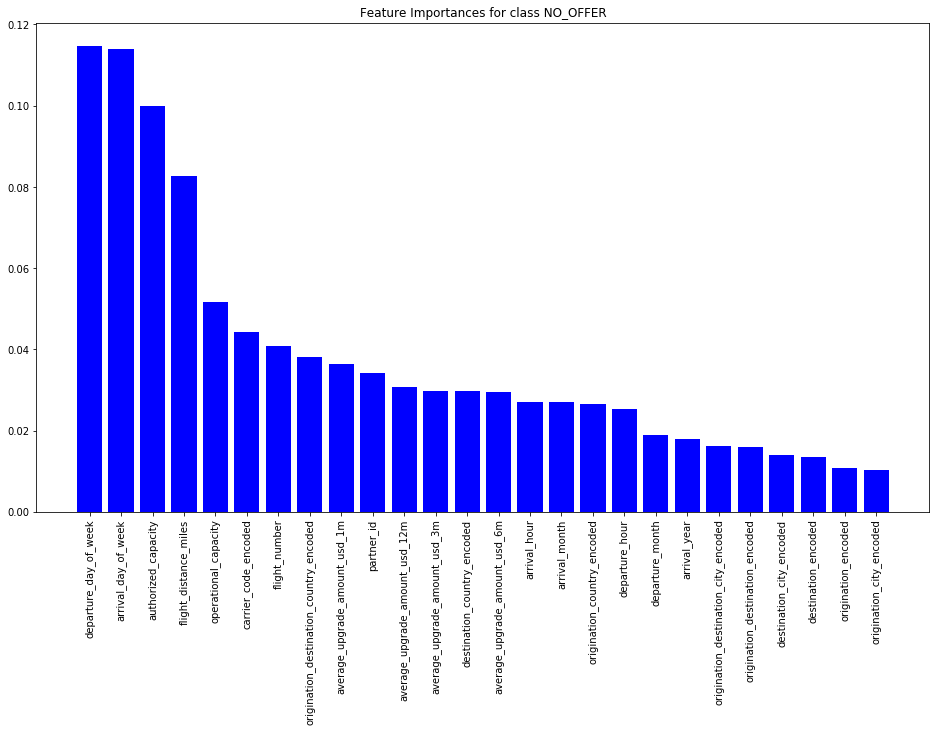

In [205]:
# run with a lot of data
train_and_evaluate(df_train,raw_df,plot_learning_curves=False, split_on_time=True)